<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/S7_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary libraries
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# mount the drive to access libraries and supportive classes
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.getcwd()
import sys
sys.path.append('/content/drive/My Drive/TSAI_EVA4')

In [4]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [5]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mean = s/n
std = np.sqrt((sq/n - np.square(mean)))
print(mean, sq/n, std, n)




[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# Data Transformation

import DataTransform
channel_means = (0.4914, 0.4822, 0.4465)
channel_stdevs = (0.3025, 0.2918, 0.2679)
trans = DataTransform.Transforms(normalize=True, mean=channel_means, stdev=channel_stdevs)
fillmeans = (np.array(channel_means)*255).astype(np.uint8)
# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=tuple(fillmeans)),
                                       transforms.RandomHorizontalFlip(),
                                       ], 
                                       
                                       [transforms.RandomErasing(value = tuple(channel_means))])

# Test Phase transformations
test_transforms = trans.test_transforms()

In [7]:
#Create Train and Test datasets
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import DataLoader

dataloader = DataLoader.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


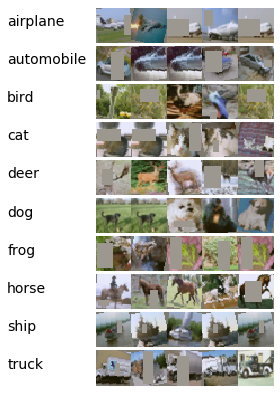

In [9]:
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))
  #return np.transpose(img, (1, 2, 0))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [10]:
import Model
model = Model.Cfar10Net4()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 20, 16, 16]           2,880
       BatchNorm2d-9           [-1, 20, 16, 16]              40
             ReLU-10           [-1, 20, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           5,760
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

In [12]:
#from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 15
L2lambda = 0
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
L1lambda = 0
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive/TSAI_EVA4", scheduler, True, L1lambda)

Validation loss decreased (100000.000000 --> 0.570379).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0051, Accuracy: 77.09%; Test set: Average loss: 0.5704, Accuracy: 79.88%
Learning Rate = 0.076211


Epoch: 2, Train set: Average loss: 0.0055, Accuracy: 75.18%; Test set: Average loss: 0.6488, Accuracy: 77.48%
Learning Rate = 0.218512


Epoch: 3, Train set: Average loss: 0.0057, Accuracy: 74.16%; Test set: Average loss: 0.6589, Accuracy: 77.55%
Learning Rate = 0.380247


Epoch: 4, Train set: Average loss: 0.0058, Accuracy: 74.20%; Test set: Average loss: 0.8551, Accuracy: 70.64%
Learning Rate = 0.485656


Epoch: 5, Train set: Average loss: 0.0057, Accuracy: 74.43%; Test set: Average loss: 0.7179, Accuracy: 75.92%
Learning Rate = 0.497179


Epoch: 6, Train set: Average loss: 0.0055, Accuracy: 75.25%; Test set: Average loss: 0.6816, Accuracy: 77.08%
Learning Rate = 0.475159


Epoch: 7, Train set: Average loss: 0.0054, Accuracy: 75.92%; Test set: Average loss: 0.6045, Accuracy: 79.34%
Learning Rate = 0.433133


Epoch: 8, Train set: Average loss: 0.0053, Accuracy: 76.44%; Test set: Average loss: 0.6132, Accuracy: 79.79%
Learning Rate = 0.374835


Epoch: 9, Train set: Average loss: 0.0051, Accuracy: 76.95%; Test set: Average loss: 0.5818, Accuracy: 80.16%
Learning Rate = 0.305444


Epoch: 10, Train set: Average loss: 0.0049, Accuracy: 78.01%; Test set: Average loss: 0.5963, Accuracy: 79.58%
Learning Rate = 0.231128


Validation loss decreased (0.570379 --> 0.540617).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0048, Accuracy: 78.50%; Test set: Average loss: 0.5406, Accuracy: 81.35%
Learning Rate = 0.158488


Validation loss decreased (0.540617 --> 0.506509).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0046, Accuracy: 79.50%; Test set: Average loss: 0.5065, Accuracy: 82.81%
Learning Rate = 0.093980


Validation loss decreased (0.506509 --> 0.486096).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0044, Accuracy: 80.44%; Test set: Average loss: 0.4861, Accuracy: 83.44%
Learning Rate = 0.043334


Validation loss decreased (0.486096 --> 0.472861).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0041, Accuracy: 81.52%; Test set: Average loss: 0.4729, Accuracy: 83.98%
Learning Rate = 0.011052


Validation loss decreased (0.472861 --> 0.468241).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0040, Accuracy: 81.80%; Test set: Average loss: 0.4682, Accuracy: 84.23%
Learning Rate = 0.000002

